Sentiment Analysis with RNNs
============================

This notebook is part of a series:

- Sentiment Analysis with RNNs - Disaster Tweets 
- Sentiment Analysis with RNNs - TripAdvisor Reviews
- Sentiment Analysis with RNNs - News Headlines Sarcasm

In this notebook we reviewed some techniques to perform sentiment analysis on a text dataset. 
We have found 4 different datasets on which we could conduct a sentiment analysis, each one containing a text and a sentiment (positive or negative).

- [IMDB Movies Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
- [Disaster tweets dataset](https://www.kaggle.com/competitions/nlp-getting-started)
- [Tripadvisor reviews](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)
- [News headlines sarcasm detection](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

This problem can be formulated as a binary classification of a text, based on the sentiment associated to each word and their structure in the sentence.

<a id="toc">Table of Contents</a>

1. [Data Analysis](#1)  
    [a. Dataset info](#1a)  
    [b. Dirty characters](#1b)
2. [Text Preprocessing](#2a)
3. [Model Experiments](#3)  
    [a. Simple FFN](#3a)  
    [b. Simple RNN](#3b)  
    [c. LSTM](#3c)  
    [d. GRU](#3d)  
    [e. 2 Layers LSTM](#3e)  
4. [Embedding Experiments](#4)  
    [a. LSTM - GloVe 6B300D](#4a)  
    [b. GRU - GloVe 6B300D](#4b)  
    [c. LSTM - GloVe Twitter 27B200D](#4c)  
    [d. GRU - GloVe 27B200D](#4d)  
5. [Contextual Embeddings](#5)

In [76]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#Uncomment the desired dataset

##IMDB dataset
#imdb_path = '../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
# data = pd.read_csv(imdb_path)
# X = data['review']
# y = pd.Series(np.where(data['sentiment'].str.contains("positive"), 1, 0))

##Disaster tweets dataset
# dis_path = '../input/nlp-getting-started/train.csv'
# data  = pd.read_csv(dis_path)
# X = data['text']
# y = data['target']

##TripAdvisor reviews
trip_path = '../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
data = pd.read_csv(trip_path)
X = data['Review']
y = pd.Series(np.where(data['Rating'] >3, 1, 0))

##News headlines sarcasm detection
# news_path = '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'
# data = pd.read_json(news_path, lines=True)
# X = data['headline']
# y = data['is_sarcastic']

# print(data.columns)
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB
None


# 1. Data Analysis
<a href="#toc" id="1">Table Of Contents</a>  

First we determine if our dataset is balanced or not between positive and negative examples

1    15093
0     5398
dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


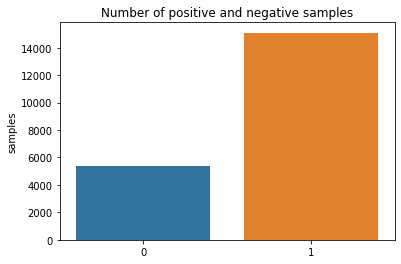

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

y_count =y.value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('Number of positive and negative samples')

print(y_count)

The twitter dataset is slightly unbalanced, with positive examples (tweets relative to disasters) being the 40% of the total.

## Characters/Words count
<a href="#toc" id="1a">Table Of Contents</a>

We can use some histograms to determine how the character and word count of the samples is distributed, in samples with positive or negative sentiment. Are positive or negative samples distributed in the same way or there is a difference in length?

12738
695


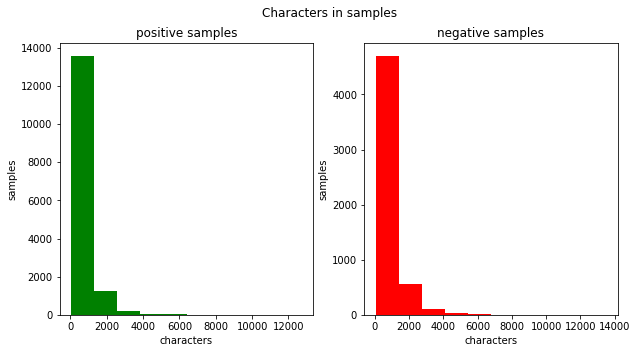

In [78]:
import math
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
X_len=X[y==1].str.len()
ax1.hist(X_len,color='green')
ax1.set_ylabel('samples')
ax1.set_xlabel('characters')
ax1.set_title('positive samples')

print(max(X_len))
print(int(X_len.mean()))

X_len=X[y==0].str.len()
ax2.hist(X_len,color='red')
ax2.set_ylabel('samples')
ax2.set_xlabel('characters')
ax2.set_title('negative samples')
fig.suptitle('Characters in samples')
plt.show()


Tweets have an average length of 108 characters, with a maximum length of 151.

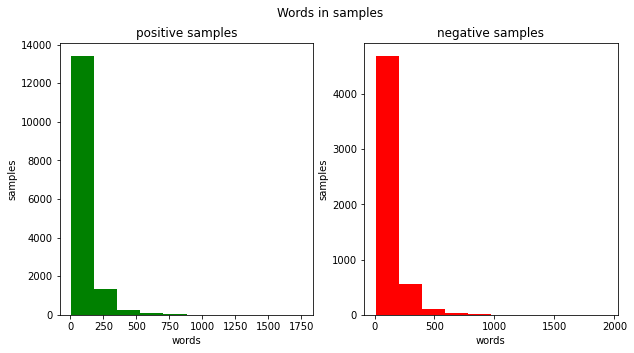

In [79]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
X_len=X[y==1].str.split().map(lambda x: len(x))
ax1.hist(X_len,color='green')
ax1.set_ylabel('samples')
ax1.set_xlabel('words')
ax1.set_title('positive samples')
X_len=X[y==0].str.split().map(lambda x: len(x))
ax2.hist(X_len,color='red')
ax2.set_ylabel('samples')
ax2.set_xlabel('words')
ax2.set_title('negative samples')
fig.suptitle('Words in samples')
plt.show()

## Dirty characters
<a href="#toc" id="1b">Table Of Contents</a>

Some datasets can contain samples with some dirty characters.
- HTML tags
- Links
- Hashtags
- Emoticons (both in single character :smile: or with composed characters :) )
- Non-ascii characters

Those characters have been removed to improve the quality of the dataset and obtain overall better results.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


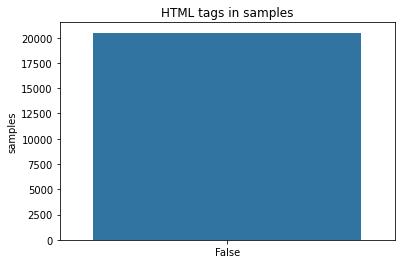

In [80]:
y_count = X.str.contains('<.*?>', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('HTML tags in samples')

X = X.str.replace(r'<.*?>','', regex= True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


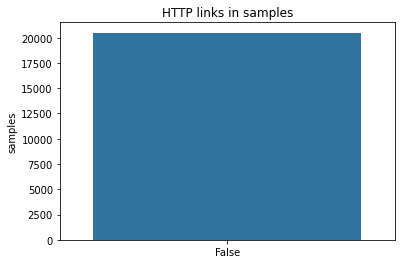

In [81]:
y_count = X.str.contains('http://+', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('HTTP links in samples')

X = X.str.replace(r'http://+','', regex= True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


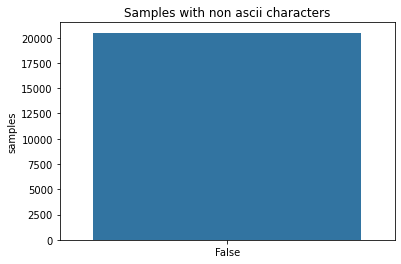

In [82]:
y_count = X.str.contains('[^[:ascii:]]', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('Samples with non ascii characters')

# print(X[X.str.contains('[^[:ascii:]]', regex= True, na=False)])
# print(X[49677])

X = X.str.replace(r'[^[:ascii:]]','', regex= True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


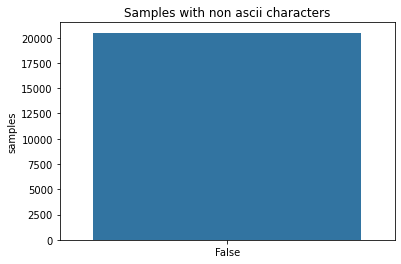

In [83]:
y_count = X.str.contains('&/?[a-z]+;', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('Samples with non ascii characters')

X = X.str.replace(r'&/?[a-z]+;','', regex= True)

# Text preprocessing
<a href="#toc" id="2">Table Of Contents</a>

Before feeding the text to the model, it needs to be tokenized.
I used the most basic [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to create the vocabulary using the train dataset, and then proceed to tokenize the train and test dataset.
There are a few parameters to decide
* Vocabulary size
* Dimension of the embedding: usually between 100 and 300
* Maximum length(in characters)
* What to do with sentences shorter or longer than maximum length
* Further reduction of the vocabulary with lemmatization or stemming.

We took a vocabulary of 1000 words, and chose a max length of 150, in accord with the size of the tweets. 
Longer tweets may be truncated, while shorter have been padded to reach an equal size of each batch. More advanced techniques may use dynamic batching, where maximum size is inferred in each batch and samples are padded accordingly.
Stemming was done with ``PorterStemmer``.

In [84]:
import nltk
import pandas as pd
import numpy as np
import re
from nltk.stem.porter import *

wpt = nltk.WordPunctTokenizer()

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')


vocab_size = 5000
embedding_dim = 300
max_length = 500
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

stemmer = PorterStemmer()

STEMMING = True
BATCH_SIZE = 64

def normalize_and_tokenize(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s!]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    if STEMMING:
        filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]
    # re-create document from filtered tokens
    return ' '.join(filtered_tokens)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


With a WordCloud we visualize the most frequent words, we'd like that stopwords or dirty characters were not shown here

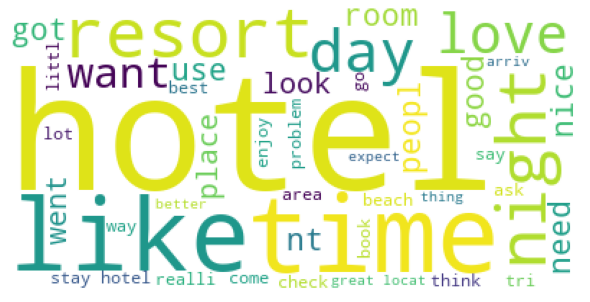

In [85]:
from wordcloud import WordCloud


X = X.map(normalize_and_tokenize)
wordcloud = WordCloud(
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(" ".join(X.to_list()))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

tokenizer = Tokenizer(num_words = vocab_size
                      ,oov_token=oov_tok
                     )

tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [87]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
train_padded = np.array(train_padded)
train_labels = np.array(y_train)
test_padded = np.array(test_padded)
test_labels = np.array(y_test)

In [88]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Model Experiments
<a href="#toc" id="3">Table Of Contents</a>
## Simple Feed Forward Network
<a href="#toc" id="3a"></a>

In [89]:
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report

optimizer=Adam(learning_rate=1e-4)

def evaluate(model,X_test,y_test):
    y_hat = model.predict(X_test,batch_size = BATCH_SIZE)
    y_hat = (y_hat > 0.5).astype(np.float32)
    if(len(y_hat.shape)>2):
        y_hat = y_hat[:,-1,0]
    report = classification_report(y_test, y_hat)
    return report

In [90]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 300)          1500000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 24)                7224      
_________________________________________________________________
dropout_80 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 25        
Total params: 1,507,249
Trainable params: 1,507,249
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/40
205/205 - 2s - loss: 0.6394 - accuracy: 0.7220 - val_loss: 0.5885 - val_accuracy: 0.7368
Epoch 2/40
205/205 - 1s - loss: 0.5850 - accuracy: 0.7389 - val_loss: 0.5702 - val_accuracy: 0.7368
Epoch 3/40
205/205 - 1s - loss: 0.5793 - accuracy: 0.7389 - val_loss: 0.5664 - val_accuracy: 0.7368
Epoch 4/40
205/205 - 1s - loss: 0.5747 - accuracy: 0.7390 - val_loss: 0.5623 - val_accuracy: 0.7368
Epoch 5/40
205/205 - 1s - loss: 0.5709 - accuracy: 0.7391 - val_loss: 0.5577 - val_accuracy: 0.7371
Epoch 6/40
205/205 - 1s - loss: 0.5638 - accuracy: 0.7396 - val_loss: 0.5509 - val_accuracy: 0.7374
Epoch 7/40
205/205 - 1s - loss: 0.5544 - accuracy: 0.7413 - val_loss: 0.5399 - val_accuracy: 0.7402
Epoch 8/40
205/205 - 1s - loss: 0.5410 - accuracy: 0.7432 - val_loss: 0.5270 - val_accuracy: 0.7438
Epoch 9/40
205/205 - 1s - loss: 0.5271 - accuracy: 0.7481 - val_loss: 0.5111 - val_accuracy: 0.7481
Epoch 10/40
205/205 - 1s - loss: 0.5095 - accuracy: 0.7563 - val_loss: 0.4916 - val_accuracy: 0.7554

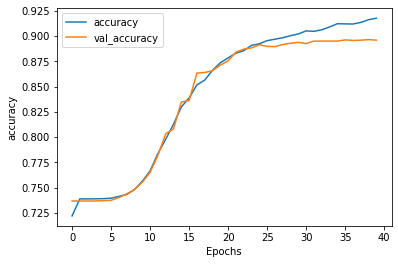

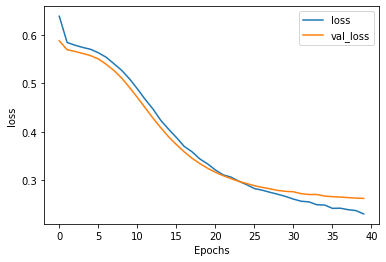

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1111
           1       0.91      0.95      0.93      2988

    accuracy                           0.89      4099
   macro avg       0.88      0.84      0.86      4099
weighted avg       0.89      0.89      0.89      4099



In [91]:
num_epochs = 40
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2, batch_size = BATCH_SIZE, verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

# Recurrent Neural Networks
<a href="#toc" id="3b">Table Of Contents</a>

For now disabled, they require too much time for training.
In addition, simple RNNs are subjected to vanishing gradient and the context is limited to a few time steps.

In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True,input_shape=(max_length, embedding_dim))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 300)          1500000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 500, 100)          35100     
_________________________________________________________________
dropout_81 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 50001     
Total params: 1,585,101
Trainable params: 1,585,101
Non-trainable params: 0
_________________________________________________________________


In [93]:
# num_epochs = 5
# history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2, verbose=2)
# plot_graphs(history, "accuracy")
# plot_graphs(history, "loss")

## LSTMs
<a href="#toc" id="3c">Table Of Contents</a>

In [94]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 300)          1500000   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 500, 64)           85248     
_________________________________________________________________
dense_24 (Dense)             (None, 500, 24)           1560      
_________________________________________________________________
dense_25 (Dense)             (None, 500, 1)            25        
Total params: 1,586,833
Trainable params: 1,586,833
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
205/205 - 14s - loss: 0.5736 - accuracy: 0.7340 - val_loss: 0.5582 - val_accuracy: 0.7408
Epoch 2/20
205/205 - 10s - loss: 0.4492 - accuracy: 0.8133 - val_loss: 0.3794 - val_accuracy: 0.8669
Epoch 3/20
205/205 - 11s - loss: 0.3551 - accuracy: 0.8799 - val_loss: 0.3819 - val_accuracy: 0.8692
Epoch 4/20
205/205 - 11s - loss: 0.3226 - accuracy: 0.8946 - val_loss: 0.3602 - val_accuracy: 0.8712
Epoch 5/20
205/205 - 11s - loss: 0.3090 - accuracy: 0.9004 - val_loss: 0.3583 - val_accuracy: 0.8762
Epoch 6/20
205/205 - 11s - loss: 0.2952 - accuracy: 0.8960 - val_loss: 0.3434 - val_accuracy: 0.8765
Epoch 7/20
205/205 - 11s - loss: 0.2792 - accuracy: 0.9121 - val_loss: 0.3562 - val_accuracy: 0.8820
Epoch 8/20
205/205 - 11s - loss: 0.2629 - accuracy: 0.9207 - val_loss: 0.3450 - val_accuracy: 0.8864
Epoch 9/20
205/205 - 11s - loss: 0.2513 - accuracy: 0.9247 - val_loss: 0.3454 - val_accuracy: 0.8843
Epoch 10/20
205/205 - 11s - loss: 0.2447 - accuracy: 0.9263 - val_loss: 0.3435 - val_accura

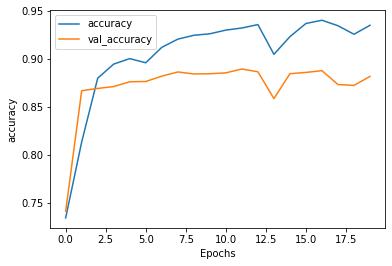

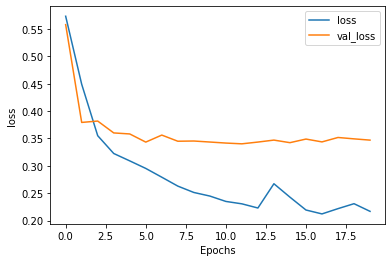

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1111
           1       0.93      0.91      0.92      2988

    accuracy                           0.88      4099
   macro avg       0.85      0.86      0.85      4099
weighted avg       0.88      0.88      0.88      4099



In [95]:
num_epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=39)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

## GRUs
<a href="#toc" id="3d">Table Of Contents</a>

In [96]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 500, 300)          1500000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 500, 64)           64128     
_________________________________________________________________
dense_26 (Dense)             (None, 500, 1)            65        
Total params: 1,564,193
Trainable params: 1,564,193
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
205/205 - 51s - loss: 0.5746 - accuracy: 0.7345 - val_loss: 0.5672 - val_accuracy: 0.7383
Epoch 2/20
205/205 - 10s - loss: 0.5595 - accuracy: 0.7431 - val_loss: 0.5576 - val_accuracy: 0.7435
Epoch 3/20
205/205 - 10s - loss: 0.5174 - accuracy: 0.7618 - val_loss: 0.3739 - val_accuracy: 0.8555
Epoch 4/20
205/205 - 10s - loss: 0.3297 - accuracy: 0.8800 - val_loss: 0.4282 - val_accuracy: 0.7978
Epoch 5/20
205/205 - 10s - loss: 0.3413 - accuracy: 0.8596 - val_loss: 0.3634 - val_accuracy: 0.8399
Epoch 6/20
205/205 - 10s - loss: 0.3101 - accuracy: 0.8881 - val_loss: 0.3826 - val_accuracy: 0.8707
Epoch 7/20
205/205 - 10s - loss: 0.2967 - accuracy: 0.8968 - val_loss: 0.3576 - val_accuracy: 0.8628
Epoch 8/20
205/205 - 10s - loss: 0.2858 - accuracy: 0.8986 - val_loss: 0.3515 - val_accuracy: 0.8675
Epoch 9/20
205/205 - 10s - loss: 0.2778 - accuracy: 0.9039 - val_loss: 0.3520 - val_accuracy: 0.8644
Epoch 10/20
205/205 - 10s - loss: 0.2712 - accuracy: 0.9081 - val_loss: 0.3518 - val_accura

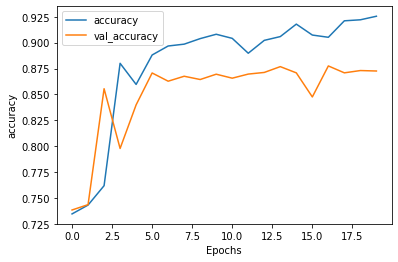

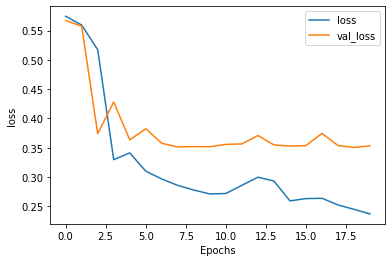

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1111
           1       0.92      0.91      0.91      2988

    accuracy                           0.88      4099
   macro avg       0.84      0.85      0.84      4099
weighted avg       0.88      0.88      0.88      4099



In [97]:
num_epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

## 2 Layers
<a href="#toc" id="3e">Table Of Contents</a>

We also tried a more complex model with 2 bidirectional LSTM layers

In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,dropout=0.5)),
#   tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 300)          1500000   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 500, 64)           85248     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 500, 64)           24832     
_________________________________________________________________
dense_27 (Dense)             (None, 500, 24)           1560      
_________________________________________________________________
dense_28 (Dense)             (None, 500, 1)            25        
Total params: 1,611,665
Trainable params: 1,611,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 20
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2, verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

Epoch 1/20
410/410 - 40s - loss: 0.5016 - accuracy: 0.7826 - val_loss: 0.3451 - val_accuracy: 0.8582
Epoch 2/20
410/410 - 33s - loss: 0.3100 - accuracy: 0.9009 - val_loss: 0.3371 - val_accuracy: 0.8754
Epoch 3/20
410/410 - 33s - loss: 0.2800 - accuracy: 0.9110 - val_loss: 0.3388 - val_accuracy: 0.8788
Epoch 4/20
410/410 - 34s - loss: 0.2611 - accuracy: 0.9201 - val_loss: 0.3323 - val_accuracy: 0.8941
Epoch 5/20
410/410 - 33s - loss: 0.2656 - accuracy: 0.9184 - val_loss: 0.3374 - val_accuracy: 0.8765
Epoch 6/20
410/410 - 33s - loss: 0.2402 - accuracy: 0.9284 - val_loss: 0.3353 - val_accuracy: 0.8876
Epoch 7/20
410/410 - 33s - loss: 0.2350 - accuracy: 0.9295 - val_loss: 0.3353 - val_accuracy: 0.8926
Epoch 8/20
410/410 - 33s - loss: 0.2345 - accuracy: 0.9275 - val_loss: 0.3270 - val_accuracy: 0.8870
Epoch 9/20
410/410 - 33s - loss: 0.2007 - accuracy: 0.9376 - val_loss: 0.3323 - val_accuracy: 0.8913
Epoch 10/20
410/410 - 33s - loss: 0.1904 - accuracy: 0.9444 - val_loss: 0.3466 - val_accura

# **GloVe pretrained word embeddings - text-preprocessing WITHOUT stemming**
<a href="toc" id="4"></a>

**text pre-processing**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# TEXT PRE-PROCESSING WITHOUT STEMMING
 
# import nltk
# import re
# from nltk.stem.porter import *


# nltk.download('stopwords')

# wpt = nltk.WordPunctTokenizer()
# stop_words = nltk.corpus.stopwords.words('english')

# vocab_size = 1000
# embedding_dim = 300
max_length = 500
# trunc_type='post'
# padding_type='post'
# oov_tok = "<UNK>"

STEMMING = False
X = X.map(normalize_and_tokenize)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

tokenizer = Tokenizer(num_words = vocab_size
                      ,oov_token= oov_tok
                     )
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

import numpy as np
train_padded = np.array(train_padded)
train_labels = np.array(y_train)
test_padded = np.array(test_padded)
test_labels = np.array(y_test)


## **LSTMs**
<a href="#toc" id="4a">Table Of Contents</a>

**import pre-trained static embeddings**

In [ ]:
# load the GloVe embedding into memory 
import numpy as np
embeddings_index = dict()
f = open("../input/glove6b/glove.6B.300d.txt")

for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs 
    
f.close()
print('Loaded %s word vectors.' %len(embeddings_index))


# create the weight matrix 
missing=0
embedding_matrix = np.zeros((len(tokenizer.word_index.items()) + 1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
    else:
        missing = missing + 1
print('%d embeddings are missing' %missing)

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, embedding_dim, weights = [embedding_matrix], input_length=max_length, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

205/205 - 15s - loss: 0.5780 - accuracy: 0.7358 - val_loss: 0.5547 - val_accuracy: 0.7493
Epoch 2/20
205/205 - 11s - loss: 0.4685 - accuracy: 0.7865 - val_loss: 0.3994 - val_accuracy: 0.8075
Epoch 3/20
205/205 - 11s - loss: 0.3815 - accuracy: 0.8233 - val_loss: 0.3589 - val_accuracy: 0.8692
Epoch 4/20
205/205 - 11s - loss: 0.3541 - accuracy: 0.8741 - val_loss: 0.3590 - val_accuracy: 0.8721
Epoch 5/20
205/205 - 11s - loss: 0.3394 - accuracy: 0.8766 - val_loss: 0.3504 - val_accuracy: 0.8818
Epoch 6/20
205/205 - 11s - loss: 0.3295 - accuracy: 0.8854 - val_loss: 0.3567 - val_accuracy: 0.8782
Epoch 7/20
205/205 - 11s - loss: 0.3649 - accuracy: 0.8745 - val_loss: 0.3669 - val_accuracy: 0.8760
Epoch 8/20
205/205 - 11s - loss: 0.3236 - accuracy: 0.8913 - val_loss: 0.3420 - val_accuracy: 0.8856
Epoch 9/20
205/205 - 11s - loss: 0.3130 - accuracy: 0.8906 - val_loss: 0.3487 - val_accuracy: 0.8846
Epoch 10/20
205/205 - 11s - loss: 0.3283 - accuracy: 0.8815 - val_loss: 0.3709 - val_accuracy: 0.8780


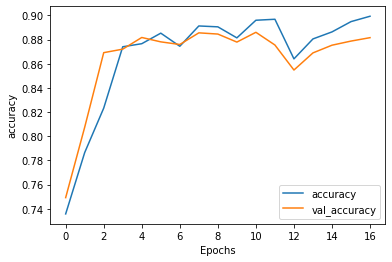

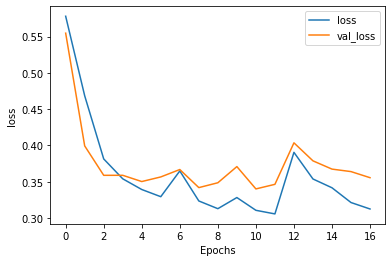

              precision    recall  f1-score   support

           0       0.87      0.61      0.71      1111
           1       0.87      0.97      0.91      2988

    accuracy                           0.87      4099
   macro avg       0.87      0.79      0.81      4099
weighted avg       0.87      0.87      0.86      4099



In [103]:
num_epochs = 20
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

## GRUs
<a href="#toc" id="4b">Table Of Contents</a>

In [104]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, embedding_dim, weights = [embedding_matrix], input_length=max_length, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
#     tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 500, 300)          15817800  
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 500, 64)           64128     
_________________________________________________________________
dense_31 (Dense)             (None, 500, 1)            65        
Total params: 15,881,993
Trainable params: 15,881,993
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
205/205 - 14s - loss: 0.5745 - accuracy: 0.7376 - val_loss: 0.5636 - val_accuracy: 0.7410
Epoch 2/20
205/205 - 10s - loss: 0.5600 - accuracy: 0.7445 - val_loss: 0.5554 - val_accuracy: 0.7464
Epoch 3/20
205/205 - 11s - loss: 0.5500 - accuracy: 0.7504 - val_loss: 0.5409 - val_accuracy: 0.7546
Epoch 4/20
205/205 - 10s - loss: 0.4437 - accuracy: 0.8056 - val_loss: 0.3754 - val_accuracy: 0.8675
Epoch 5/20
205/205 - 10s - loss: 0.4683 - accuracy: 0.7346 - val_loss: 0.3941 - val_accuracy: 0.7643
Epoch 6/20
205/205 - 10s - loss: 0.3539 - accuracy: 0.8325 - val_loss: 0.3709 - val_accuracy: 0.8676
Epoch 7/20
205/205 - 10s - loss: 0.3446 - accuracy: 0.8712 - val_loss: 0.4041 - val_accuracy: 0.8657
Epoch 8/20
205/205 - 10s - loss: 0.3238 - accuracy: 0.8898 - val_loss: 0.3650 - val_accuracy: 0.8722
Epoch 9/20
205/205 - 10s - loss: 0.3496 - accuracy: 0.8799 - val_loss: 0.3746 - val_accuracy: 0.8685
Epoch 10/20
205/205 - 10s - loss: 0.3307 - accuracy: 0.8884 - val_loss: 0.3958 - val_accura

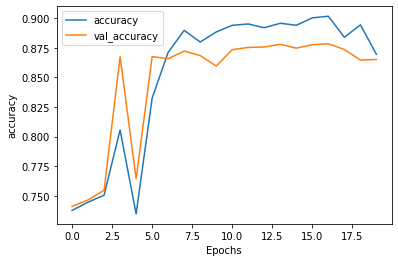

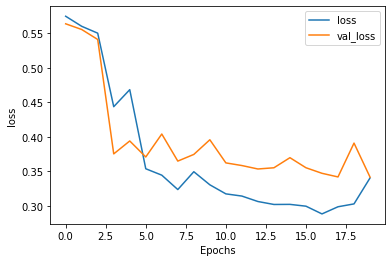

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1111
           1       0.93      0.87      0.90      2988

    accuracy                           0.86      4099
   macro avg       0.82      0.85      0.83      4099
weighted avg       0.87      0.86      0.86      4099



In [105]:
num_epochs = 20
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

# **GloVe pre-trained static embedding on Twitter data - without STEMMING**

The quality of embeddings is crucial for the performance: we tried another set of pretrained embedding, of dimension 200 instead of 300 but trained on Twitter data.
Since these embeddings may be similar to the dataset we are evaluating, they may lead to a better performance.

## **LSTMs**
<a href="#toc" id="4c">Table Of Contents</a>

**import GloVe static embedding pre trained on twitter data with 200 dimension**

In [106]:

# load the GloVe embedding into memory 
import numpy as np
twitter_embeddings_index = dict()
f = open("../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt")



for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    twitter_embeddings_index[word] = coefs 
    
f.close()
print('Loaded %s word vectors.' %len(twitter_embeddings_index))


# create the weight matrix 
missing=0
twitter_embedding_matrix = np.zeros((len(tokenizer.word_index.items()) + 1, 200))

for word, i in tokenizer.word_index.items():
    twitter_embedding_vector = twitter_embeddings_index.get(word)
    if twitter_embedding_vector is not None: 
        twitter_embedding_matrix[i] = twitter_embedding_vector
    else:
        missing = missing + 1
print('%d embeddings are missing' %missing)


Loaded 1193514 word vectors.
34958 embeddings are missing


**LSTMs model definition**

In [107]:

import tensorflow as tf
from tensorflow import keras
twitter_embedding_dim = 200
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, twitter_embedding_dim, weights = [twitter_embedding_matrix], input_length=max_length, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, twitter_embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 500, 200)          10545200  
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 500, 64)           59648     
_________________________________________________________________
dense_32 (Dense)             (None, 500, 24)           1560      
_________________________________________________________________
dense_33 (Dense)             (None, 500, 1)            25        
Total params: 10,606,433
Trainable params: 10,606,433
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
205/205 - 14s - loss: 0.5757 - accuracy: 0.7382 - val_loss: 0.5601 - val_accuracy: 0.7419
Epoch 2/20
205/205 - 10s - loss: 0.5199 - accuracy: 0.7696 - val_loss: 0.4428 - val_accuracy: 0.8347
Epoch 3/20
205/205 - 10s - loss: 0.3966 - accuracy: 0.8443 - val_loss: 0.3842 - val_accuracy: 0.8379
Epoch 4/20
205/205 - 10s - loss: 0.3756 - accuracy: 0.8557 - val_loss: 0.3968 - val_accuracy: 0.8561
Epoch 5/20
205/205 - 10s - loss: 0.3713 - accuracy: 0.8642 - val_loss: 0.3883 - val_accuracy: 0.8590
Epoch 6/20
205/205 - 10s - loss: 0.3683 - accuracy: 0.8677 - val_loss: 0.3959 - val_accuracy: 0.8590
Epoch 7/20
205/205 - 10s - loss: 0.3729 - accuracy: 0.8691 - val_loss: 0.4307 - val_accuracy: 0.8417
Epoch 8/20
205/205 - 10s - loss: 0.4031 - accuracy: 0.8540 - val_loss: 0.4243 - val_accuracy: 0.8460
Epoch 9/20
205/205 - 10s - loss: 0.3705 - accuracy: 0.8713 - val_loss: 0.3887 - val_accuracy: 0.8625
Epoch 10/20
205/205 - 10s - loss: 0.3466 - accuracy: 0.8803 - val_loss: 0.3943 - val_accura

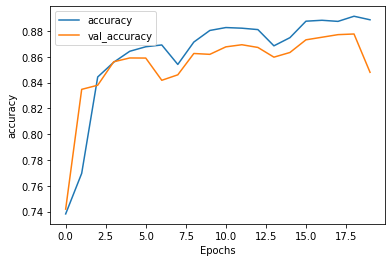

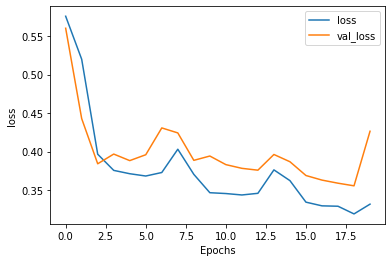

              precision    recall  f1-score   support

           0       0.65      0.86      0.74      1111
           1       0.94      0.82      0.88      2988

    accuracy                           0.83      4099
   macro avg       0.79      0.84      0.81      4099
weighted avg       0.86      0.83      0.84      4099



In [108]:
num_epochs = 20
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

## GRUs
<a href="#toc" id="4d">Table Of Contents</a>

In [109]:
import tensorflow as tf
import keras
twitter_embedding_dim = 200
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, twitter_embedding_dim, weights = [twitter_embedding_matrix], input_length=max_length, trainable=False),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True,input_shape=(max_length, twitter_embedding_dim))),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 500, 200)          10545200  
_________________________________________________________________
dropout_82 (Dropout)         (None, 500, 200)          0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 500, 64)           44928     
_________________________________________________________________
dense_34 (Dense)             (None, 500, 24)           1560      
_________________________________________________________________
dense_35 (Dense)             (None, 500, 1)            25        
Total params: 10,591,713
Trainable params: 10,591,713
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
205/205 - 13s - loss: 0.5785 - accuracy: 0.7358 - val_loss: 0.5660 - val_accuracy: 0.7377
Epoch 2/20
205/205 - 9s - loss: 0.5602 - accuracy: 0.7431 - val_loss: 0.5546 - val_accuracy: 0.7479
Epoch 3/20
205/205 - 9s - loss: 0.5444 - accuracy: 0.7541 - val_loss: 0.5269 - val_accuracy: 0.7622
Epoch 4/20
205/205 - 9s - loss: 0.4026 - accuracy: 0.8325 - val_loss: 0.3460 - val_accuracy: 0.8797
Epoch 5/20
205/205 - 9s - loss: 0.3411 - accuracy: 0.8869 - val_loss: 0.3635 - val_accuracy: 0.8779
Epoch 6/20
205/205 - 9s - loss: 0.3046 - accuracy: 0.8972 - val_loss: 0.3248 - val_accuracy: 0.8882
Epoch 7/20
205/205 - 9s - loss: 0.2950 - accuracy: 0.8991 - val_loss: 0.3259 - val_accuracy: 0.8775
Epoch 8/20
205/205 - 9s - loss: 0.3051 - accuracy: 0.8841 - val_loss: 0.3287 - val_accuracy: 0.8587
Epoch 9/20
205/205 - 9s - loss: 0.2957 - accuracy: 0.8906 - val_loss: 0.3251 - val_accuracy: 0.8797
Epoch 10/20
205/205 - 9s - loss: 0.3701 - accuracy: 0.8214 - val_loss: 0.3350 - val_accuracy: 0.848

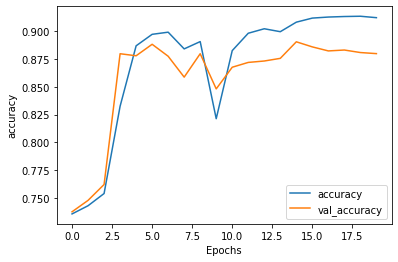

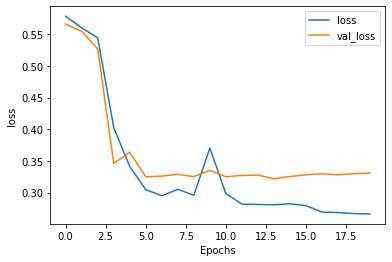

              precision    recall  f1-score   support

           0       0.76      0.83      0.80      1111
           1       0.94      0.90      0.92      2988

    accuracy                           0.88      4099
   macro avg       0.85      0.87      0.86      4099
weighted avg       0.89      0.88      0.89      4099



In [110]:
num_epochs = 20
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

# Contextual Embeddings
<a href="#toc" id="5">Table Of Contents</a>

In [111]:
from transformers import BertTokenizer, TFBertModel
from tqdm.notebook import tqdm

import tensorflow_hub as hub

# bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [112]:
max_length = 500

sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,truncation=True,max_length =max_length,
return_attention_mask = True)
tokenized_sequence

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [113]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP]'

In [114]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

def bert_encode(data, max_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

def create_bert(bert_model,max_length):
    
    input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [115]:
model = create_bert(bert_model,max_length)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 109482240   input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 32)           24608       tf_bert_model_2[0][1]      

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [116]:
input_ids=[]
attention_masks=[]

for sent in X:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,truncation=True,max_length =max_length,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
y=np.array(y)

train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,y,attention_masks,test_size=0.2)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [117]:
import tensorflow as tf
import keras

# callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir),tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]
# history=model.fit([train_inp,train_mask],train_label,batch_size=BATCH_SIZE,epochs=10,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks,verbose=2)

history = model.fit(
    [train_inp, train_mask],
    train_label,
    validation_split=0.2, 
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=2
)



Epoch 1/10


2022-07-23 11:49:26.612795: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 732.42MiB (rounded to 768000000)requested by op model_3/tf_bert_model_2/bert/encoder/layer_._2/attention/self/Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-07-23 11:49:26.612968: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-07-23 11:49:26.613003: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (256): 	Total Chunks: 268, Chunks in use: 266. 67.0KiB allocated for chunks. 66.5KiB in use in bin. 6.2KiB client-requested in use in bin.
2022-07-23 11:49:26.613016: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (512): 	Total Chunks: 33, Chunks in use: 33. 20.5KiB allocated for chunks. 20.5KiB in use in bin. 19.8K

ResourceExhaustedError:  OOM when allocating tensor with shape[64,12,500,500] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_3/tf_bert_model_2/bert/encoder/layer_._2/attention/self/Softmax (defined at opt/conda/lib/python3.7/site-packages/transformers/tf_utils.py:70) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_466845]

Function call stack:
train_function


In [ ]:
report = evaluate(model,[val_inp,val_mask],val_label)
print(report)

In [ ]:
import matplotlib.pyplot as plt
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")